# Google Colab
Set the Runtime to GPU from the menu on the top left of this webpage

Importing data to Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Copy data to google colab from google drive and unzip
# This may take 1-2 minutes
!cp gdrive/My\ Drive/optical_data.zip .
!unzip optical_data.zip

In [3]:
# You should be able to see 7 Classes here
!ls data

Class1	Class2	Class3	Class4	Class5	Class6	Class7


Sample Output : Class1 Class2	Class3	Class4	Class5	Class6	Class7

# Main Notebook

In [4]:
import os
import sys
import time
import warnings
from random import shuffle

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
import numpy as np
import keras
from keras import backend as K
import cv2
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Data Loading

In [0]:
# Not all data in the dataset has defects. We only use the images which have defects
# This function takes the dataset_type as a parameter. You can pass "Train" or "Test"
# as argument to get the appropriate dataset
def load_data(dataset_type="Train"):
    file_list = {}
    defect_map = {}
    file_name = []
    file_mask = []
    count = 0
    num_classes = 6

    data_dir = "data"
    for x in range(1, num_classes + 1):
        path = os.path.join(os.path.join(data_dir, "Class" + str(x)), dataset_type)
        df = pd.read_fwf(path + "/Label/Labels.txt")
        count = 0
        for i in range(0, len(df)):
            curr_file = path + "/" + str(df.iloc[i][2])
            if (df.iloc[i][1] == 1):
                file_list[curr_file] = path + "/Label/" + str(df.iloc[i][4])
                defect_map[curr_file] = 1
            else:
                fnametest = str(df.iloc[i][2]).split(".")
                file_list[curr_file] = str(path + "/Label/" + fnametest[0] + "_label.PNG")
                defect_map[curr_file] = 0

    items = list(file_list.keys())
    shuffle(items)
    for key in items:
        if ((not os.path.exists(key)) or (not os.path.exists(file_list[key]))):
            # print ("Missing mask for ", key)
            continue

        if defect_map[key] == 1:
            file_name.append(key)
            file_mask.append(file_list[key])
        elif count < 80 * num_classes:
            file_name.append(key)
            file_mask.append(file_list[key])
            count = count + 1

    return file_name, file_mask

Since the dataset is so large that it cannot fit into memory, we will need to use generator functions to iteratively load the dataset

In [0]:
# This is generator class to process data in batches and send them for training
class Surface_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, test=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    # return the total number of batches you have i.e., total_files/batch_size
    def __len__(self):
        return (len(self.image_filenames) // self.batch_size)

    # this function is called for every mini-batch to get the images/masks for that mini-batch
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_arr = []
        mask_arr = []
        # Open a batch of images and their corresponding masks using cv2.imread
        # resize them to 512x512x1 and return an np.array of images and masks
        for file in batch_x:
          image_arr.append(resize(cv2.imread(file),(512,512,1)))
        for file in batch_y:
          img = cv2.imread(file)
          gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          thresh, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
          mask_arr.append(resize(binary,(512,512,1)))
          
        return np.array(image_arr).astype(np.float32), np.array(mask_arr).astype(np.float32)
    
    # for testing we need to get the list of all true masks
    # this function should return all the labels in the dataset set 
    # we will call this function only for the "Test" dataset
    def get_all_masks(self):
        mask_arr = []
        
        for file in self.image_filenames:
          img = cv2.imread(file)
          gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          #thresh, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
          mask_arr.append(resize(gray,(512,512,1)))
        return np.array(mask_arr).astype(np.float32)


In [0]:
# Since we already have a split for training and test set,
# we just need to split training set to get a validation set

# Load training data
X, Y = load_data("Train")


In [8]:
# Split the original training data to get training and validation set
# to get X_train, X_val, y_train, y_val
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split( X, Y, test_size=0.2)

# Convert to numpy arrays
X_train = np.array(X_train_data)
X_val = np.array(X_val_data)
y_train = np.array(y_train_data)
y_val = np.array(y_val_data)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(740,) (740,) (186,) (186,)


The output shape after the split should be 
(740,) (740,) (186,) (186,)

In [9]:
# Free memory
import gc
del X
del Y
gc.collect()

170

# Metrics

Use keras.backend to calculate dice coefficient metric and dice coefficient loss function.

Recall that dice_coeff = 2 \* intersection / union

We add a smoothing parameter and modify the formula to

dice_coeff = 2 \* (intersection + smooth) / (union + smooth)

Our objective is to make dice_coeff as close to 1.0 as possible. 
Define and use the appropriate loss function.

In [0]:
# Dice Coefficient metric
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    


# Dice Coefficient loss
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Model

U-net architeture has proved to be very powerful for segmentation tasks.

We will be creating a Unet model based on the paper : 

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

---

A picture of the architecture we plan to use is provided in the project description pdf.

We will create a Convolutional block module to help us build the model.

Each convolutional block module will contain two trainable layers. 

Each layer will be a Convolution operation followed by batch normalization with relu activation.



The U-net architecture has a contracting path, a convolution and then an expansive path.

We will use instances of the convolutional block to create the contracting and expansive path.

In [0]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv1D, Flatten
from keras.models import Model

# Create a 2D convolution block. We will use multiple instances of this block to build our U-net model
# This block will contain two layers. 
# Each layer will be a Convolution operation followed by batch normalization with relu activation 
def conv2d_block(input_tensor, n_filters, kernel_size):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal' )(input_tensor)    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding='same', kernel_initializer='he_normal' )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # return the output tensor
    return x


def get_unet_model(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((512, 512, 1))
    
    # contracting path
    c1 = conv2d_block(input_img, n_filters, kernel_size)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)
    p1 = Dropout(0.5*dropout_prob)(p1)

    c2 = conv2d_block(p1, 2*n_filters, kernel_size)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)
    p2 = Dropout(0.5*dropout_prob)(p2)

    c3 = conv2d_block(p2, 4*n_filters, kernel_size)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)
    p3 = Dropout(0.5*dropout_prob)(p3)

    c4 = conv2d_block(p3, 8*n_filters, kernel_size)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    p4 = Dropout(0.5*dropout_prob)(p4)

    c5 = conv2d_block(p4, 16*n_filters, kernel_size)
    
    # Expansive path
    u6 = Conv2DTranspose(filters = 8*n_filters, kernel_size = (kernel_size, kernel_size), padding='same',strides = (2,2) )(c5)
    u6 = Concatenate()([c4, u6])
    u6 = Dropout(0.5*dropout_prob)(u6)
    c6 = conv2d_block(u6, 8*n_filters, kernel_size)
    
    u7 = Conv2DTranspose(filters = 4*n_filters, kernel_size = (kernel_size, kernel_size), padding='same',strides = (2,2) )(c6)
    u7 = Concatenate()([c3, u7])
    u7 = Dropout(0.5*dropout_prob)(u7)
    c7 = conv2d_block(u7, 4*n_filters, kernel_size)
    
    u8 = Conv2DTranspose(filters = 2*n_filters, kernel_size = (kernel_size, kernel_size), padding='same',strides = (2,2) )(c7)
    u8 = Concatenate()([c2, u8])
    u8 = Dropout(0.5*dropout_prob)(u8)
    c8 = conv2d_block(u8, 2*n_filters, kernel_size)

    u9 = Conv2DTranspose(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding='same',strides = (2,2) )(c8)
    u9 = Concatenate()([c1, u9])
    u9 = Dropout(0.5*dropout_prob)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size)
    #c9 = Flatten()(c9)
    
    outputs = Conv2D(filters = 1, kernel_size = (1, 1), activation = 'sigmoid' )(c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [0]:
model_name = "unet"
model = get_unet_model()

In [0]:
batch_size = 8
num_epochs = 50
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])

In [0]:
num_training_samples = len(X_train)
num_validation_samples = len(X_val)

training_batch_generator = Surface_Generator(X_train_data, y_train_data, batch_size)
validation_batch_generator = Surface_Generator(X_val_data, y_val_data, batch_size)

In [0]:
# callbacks for saving models and early stopping
checkpointer = ModelCheckpoint(model_name + "/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor=dice_coef, verbose=1,
                               save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [16]:
# Fit model
stmillis = int(round(time.time() * 1000))
history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1,
                    callbacks=[checkpointer])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Epoch 1/50
91/92 [============================>.] - ETA: 1s - loss: 0.8967 - dice_coef: 0.1033Epoch 1/50
Epoch 1/50
92/92 [==============================] - 144s 2s/step - loss: 0.8966 - dice_coef: 0.1034 - val_loss: 0.9637 - val_dice_coef: 0.0323
Epoch 2/50
92/92 [==============================] - 124s 1s/step - loss: 0.9112 - dice_coef: 0.0888 - val_loss: 0.9623 - val_dice_coef: 0.0340
Epoch 3/50
92/92 [==============================] - 125s 1s/step - loss: 0.7324 - dice_coef: 0.2676 - val_loss: 0.8819 - val_dice_coef: 0.0636
Epoch 4/50
92/92 [==============================] - 125s 1s/step - loss: 0.6825 - dice_coef: 0.3175 - val_loss: 0.5464 - val_dice_coef: 0.2787
Epoch 5/50
92/92 [==============================] - 125s 1s/step - loss: 0.6876 - dice_coef: 0.3124 - val_loss: 0.9212 - val_dice_coef: 0.0568
Epoch 6/50
92/92 [==============================] - 125s 1s/step - loss: 0.6758 - dice_coef: 0.3242 - val_loss: 0.7977 - val_dice_coef: 0.1731
Epoch 7/50
92/92 [===================

In [0]:
# Save the trained weights
model.save(model_name + ".h5")

# Save model config as json
model_json = model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp unet.* gdrive/My\ Drive/

In [18]:
# Confirm if model did get saved
!ls -ltr gdrive/My\ Drive/unet*

-rw------- 1 root root 26252328 Jun  1 18:15 'gdrive/My Drive/unet.h5'
-rw------- 1 root root    35219 Jun  1 18:15 'gdrive/My Drive/unet.json'


In [0]:
# In case you wish to load your saved model
!cp gdrive/My\ Drive/unet* .

model.load_weights("unet.h5")

In [20]:
import gc
gc.collect()

# Load test data in X_test and y_test
X_test_data, y_test_data = load_data("Test")
X_test = np.array(X_test_data)
y_test = np.array(y_test_data)
print (X_test.shape, y_test.shape)

(454,) (454,)


Output shape should be (454,) (454,)

In [0]:
np.random.seed = 629
p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

In [22]:
# Predict using model.predict_generator().
num_testing_samples = len(X_test)
batch_size = 2

test_data_generator = Surface_Generator(X_test_data, y_test_data, batch_size)
y_pred = model.predict_generator(generator=test_data_generator,
                    steps=(num_testing_samples // batch_size),
                    verbose=1,
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1)

227/227 [==============================] - 42s 187ms/step


In [23]:
# y_true will have the true masks
y_true = test_data_generator.get_all_masks()
#print(np.round(y_pred))

print ("Dice coefficient on test data: ", K.get_value(dice_coef(y_true, y_pred)))

Dice coefficient on test data:  0.017973376


Visulaizing the mask for a random image

In [0]:
# Convert sigmoid outputs to binary class labels
y_pred[20][y_pred[20] >= 0.5] = 1
y_pred[20][y_pred[20] < 0.5] = 0

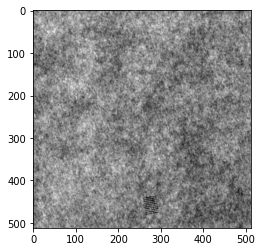

In [25]:
import matplotlib.pyplot as plt
plt.imshow(y_true[20][:,:,0], cmap='gray')
plt.show()

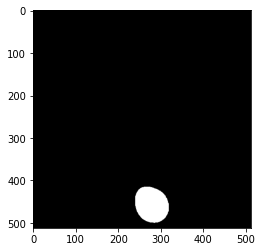

In [26]:
plt.imshow(y_pred[20][:,:,0], cmap='gray')
plt.show()

In [27]:
# Dice coefficient on this example
K.get_value(dice_coef(y_true[20], y_pred[20]))

0.03394568

Data augmentation techniques almost always help in improving the performance of deep learning models.